<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Расширенное исследование задачи классификации тональности текста с использованием предобученных моделей NLP

1. проверка использования в качестве признаков не только целого комментария но и отдельных предложений из комментария (работа sentence tokenizer NLTK)

2. отработка работы BERT, использование различных слоев BERT в качестве признаков, и комбинаций этих слоев

  - В первом исследовании построена простая сеть с использованием API Keras над Tensorflow, здесь применяется PyTorch: создание модели со встроенным трансформером BERT и собственным классификатором из полносвязных слоев.
  - Работа со слоями BERT моделей:  получение состояний предпоследнего  слоя трансформера BERT,  вообще работа c тензорами их выводов и использование полученных  данных в качестве входных векторов в самостоятельно добавленных полносвязных слоях, все в рамках одной созданной модели

  - Хотя в среднем лучшие результаты согласно исследованиям авторов BERT дает контактенация состояний последних четырех слоев в единый вектор, здесь применена именно раздельная классификация через сеть с последним слоем размерностью 3 (кол-во классов) этих четырех наборов, которые я описал выше, нормализация их выходов в диапазоне 0-1 и усреднение.
  - Таким образом нивелируются встраивания контекстной информации полученной в последних слоях трансформера, для того чтобы меньше зависеть от контекста именно этого датасета.
  - Далее сеть обучена на тренировочной выборке (разделение трейн/вал/тест примерно 81/9/10 %) проверена на валидационной и заново обучена на тренировочной + валидационной выборке (90% от исходных данных)
  - Модель сохраняется на диск, загружается и предсказывает классы из тестовой выборки. F1 macro на тестовой выборке от 0,92 до 0,98 в зависимости от распределения данных в тесте. 
  - Эти результаты могут быть использованы как входные данные для задачи исследования ошибок модели, для улучшения ее предсказаний путем дополнительной предобработки данных

Сейчас в задаче предусмотрена только единственная предобработка: исправление вот таких комбинаций ['сЛОВО' | 'cЛОВо' | 'СЛОво' | 'СЛОВО' (not 'Слово')] -> 'слово' c использованием регулярных выражений
  - в качестве выходных данных модели использованы 4 набора выходов, полученных после  независимого прохождения через слои - классификаторы следующих тензоров
     1) эмбеддинг токена классификатора из последнего слоя трансформера bert
     2) усредненное значение  эмбеддингов всех токенов из предпоследнего слоя bert
     3) усредненное значение  эмбеддингов всех токенов из последнего слоя bert
     4) поэлементная сумма состояний последних четырех слоев bert c итоговым усредненим

3. Решение задач распознавания сущностей NER
  - использовалась русскоязычная модель DeepPavlov ner_rus_bert_probas, обученная на данных из Википедии
  - модель в дополнение к предсказаниям классов добавляет series содержащий строки с размеченными сущностями, если они найдены (теги PER LOC ORG PRODUCT и пр)

### Загрузка библиотек

In [ ]:
!pip install transformers #==4.24.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import requests
import urllib
import json
import re

from tqdm  import tqdm 

import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch import nn, optim

from transformers import AutoConfig, AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Глобальные переменные / Функции общего назначения

In [ ]:
RANDOM_STATE = 3141592654

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('DEVICE SET TO ', DEVICE)

YANDEX_DIR = 'https://disk.yandex.ru/d/u-dNhLqS9_1mFQ'
DATA_FILE = 'data.csv'

RANDOM_STATE = 3141592654 # int, состояние генератора, 3141592654 by default
CV_VALUE = 5              # Количество фолдов для CV, 5 by default

SCORER = 'f1_macro'       # str, Тип метрики для анализа
AVG_F1 = 'macro'          # str, Тип усреднения для F1
METRIC_MAX_LIMIT = 1      # float, Предельное максимальное значение метрики
METRIC_MIN_LIMIT = 0.92   # float, Предельное минимальное значение метрики

RAW = True                # Bool, Если True - использовать сырые данные

DEVICE SET TO  cuda:0


In [ ]:
def get_direct_path_yadisk(folder_url, filename):
    '''
    makes a direct link (for download) to the file 
    located in the Yandex disk public link
    '''
    url = ('https://cloud-api.yandex.net/v1/disk/public/resources/download' +
           '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + 
           urllib.parse.quote(filename))
    r = requests.get(url) 
    return json.loads(r.text)['href']    

### Загрузка и преобразование данных

In [ ]:
data = pd.read_csv(get_direct_path_yadisk(YANDEX_DIR, DATA_FILE), sep=';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1763 non-null   object
 1   class   1763 non-null   object
dtypes: object(2)
memory usage: 27.7+ KB


Преобразование текстовых меток в числовые

In [ ]:
enc_labels = LabelEncoder()
data['class_labels'] = enc_labels.fit_transform(data['class'])
labels_dict = {
    i: list(enc_labels.classes_)[i] for i in range(0, 
                                                   len(list(
                                                       enc_labels.classes_
                                                       )))
    }

display(data.head(10))
print('Словарь ключей классов')
display(pd.DataFrame(labels_dict.values(), index=labels_dict.keys()))

,text,class,class_labels
0,Невнимательность к покупателю. Товар выносят п...,Товар,2
1,Посудомоечная машина не исправна. Остальной то...,Товар,2
2,"Приехал в магазин, оказался только Витринный о...",Товар,2
3,Несколько раз переносили дату доставки.,Доставка,0
4,"На сайте было написано бесплатная доставка,а п...",Доставка,0
5,На пункте выдачи нет сотрудника._x000D_\n,Магазин,1
6,"Продавцы не должны запугивать клиента, чтобы о...",Магазин,1
7,Ассортимент печальный.,Товар,2
8,Заказ не доставлен. По телефону сотрудница маг...,Доставка,0
9,"оператор не располагал данной информацией,в ма...",Магазин,1


Словарь ключей классов


,0
0,Доставка
1,Магазин
2,Товар


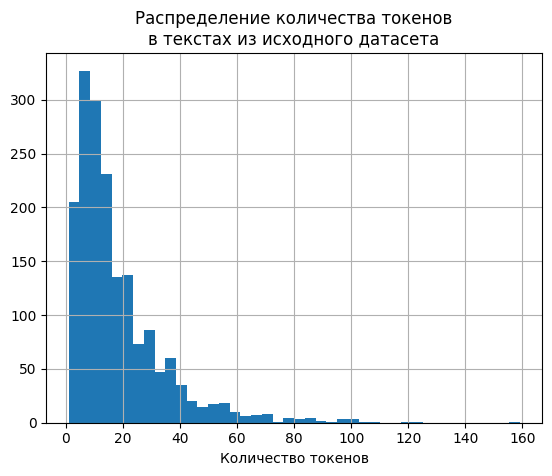

In [ ]:
list_of_word_counts = [
    len(str(text_).split()) for text_ in data['text'].to_list()
    ]
pd.Series(list_of_word_counts).hist(bins = 42)
plt.title('Распределение количества токенов\n\
в текстах из исходного датасета')
plt.xlabel('Количество токенов')
plt.show()

#### Создание датасета с предложениями

In [ ]:
data_connl = pd.DataFrame()

for idx_, row in tqdm(data.iterrows(), total=len(data)):
    sentenized_text=sent_tokenize(row['text'])
    #print(row.keys())
    data_connl = pd.concat(
        [data_connl,
         pd.DataFrame({'sentence': sentenized_text,
                       'class': row['class'],
                       'class_labels': row['class_labels']})])
    
data_connl.reset_index(drop=True, inplace=True)   
data_connl['token_count'] = data_connl['sentence'].str.count(r'\b\w+\b')
data_connl['char_count'] = data_connl['sentence'].str.count(r'.')

100%|██████████| 1763/1763 [00:03<00:00, 574.31it/s]


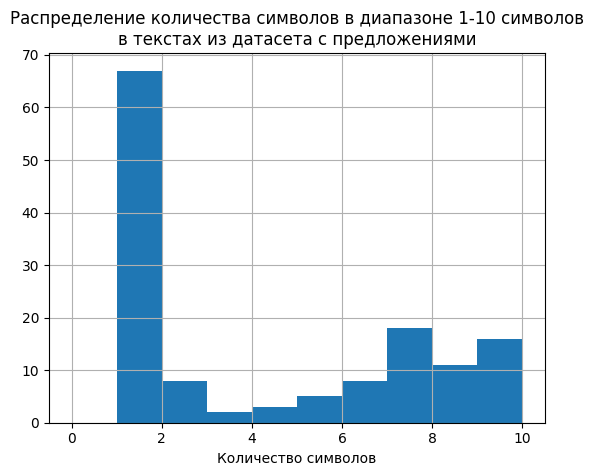

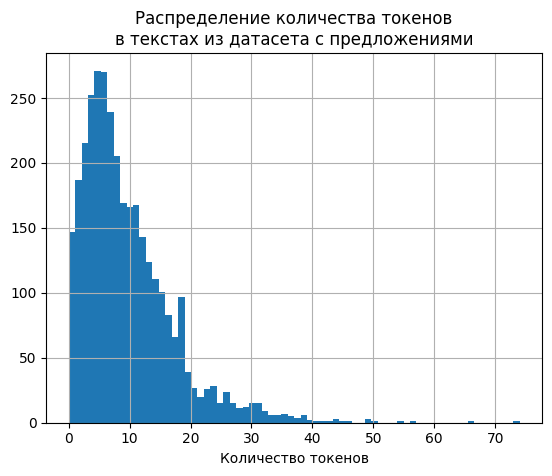

In [ ]:
data_connl['char_count'].hist(bins = 10, range=(0, 10))
plt.title('Распределение количества символов в диапазоне 1-10 символов\n\
в текстах из датасета с предложениями')
plt.xlabel('Количество символов')
plt.show()

data_connl['token_count'].hist(bins = 70)
plt.title('Распределение количества токенов\n\
в текстах из датасета с предложениями')
plt.xlabel('Количество токенов')
plt.show()


In [ ]:
# В датасете с предложениями оставляем только объекты с длиной символов > 3
data_connl = data_connl.query('char_count > 3').reset_index(drop=True)  

### Создание набора данных для моделей BERT

In [ ]:
# Если использовать СЫРОЙ текст установить RAW = True, 
# иначе используется датасет с предложениями
RAW = True

if RAW:
    text_ = data['text']
    labels_ = data['class_labels']
    # Максимальное кол-во значащих векторов в эмбеддинге 
    # установить в соответствии с распределением кол-ва токенов
    max_length = 160
else:
  text_ = data_connl['sentence']
  labels_ = data_connl['class_labels']
  max_length = 90

In [ ]:
# Выделение тестовой части 90/10

X_full_train, X_test, y_full_train, y_test = train_test_split(
    text_,
    labels_, 
    test_size=0.1, random_state = RANDOM_STATE, 
    shuffle=True, stratify=labels_
    )

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [ ]:
def series_ptrn_replace(
    series_, 
    ptrn_=r'(\b[А-ЯЁ]+\b)|(\b[а-яё]+[А-ЯЁ]+\b)|(\b[а-яё]+[А-ЯЁ]+[а-яё]+\b)'
    ):
    '''
    series_: pd.Series with texts
    ptrn_: regex patter
    Text preprocessing. Pattern reduction to lowercase
    Default template (Cyrillic only)
    ['сЛОВО' | 'cЛОВо' | 'СЛОво' | 'СЛОВО'] -> 'слово'
    Но 'Слово' -> 'Слово' (не изменяется)
    '''

    def lower_(match_): 
        return str.lower(match_.group())
        
    if type(series_) is not pd.core.series.Series:
        try:
            series_ = pd.Series(series_)
            print('Преобразовано в pd.Series.')
        except:
            print('Преобразование в pd.Series не удалось!')
            return series_
    try:
        return_series = series_.str.replace(ptrn_, lower_, regex=True)
        print('Обработка завершена успешно.')
    except:
        print('Замена слов по шаблону не удалась!')
        return series_
    return return_series

In [ ]:
X_full_train = series_ptrn_replace(X_full_train)

Обработка завершена успешно.


In [ ]:
# Токенизация текстов. Для всех данных кроме теста

X_full_train_tokens = tokenizer.batch_encode_plus(
    X_full_train.to_list(),
    max_length = max_length,
    padding = 'max_length',
    truncation = True,
    add_special_tokens = True, #default
    is_split_into_words = False, #default
)

In [ ]:
# Выделение валидационной выборки 90/10

(X_train_id, X_val_id, 
 X_train_mask,  X_val_mask,  
 y_train, y_val) = train_test_split(
     X_full_train_tokens['input_ids'],
     X_full_train_tokens['attention_mask'], 
     y_full_train,
     test_size=0.1, random_state = RANDOM_STATE, 
     shuffle=True, stratify=y_full_train
     )

print('X train len =', len(X_train_id))
print('y train len =', len(y_train))

print('X val len =', len(X_val_id))
print('y val len =', len(y_val))

print('X test len =', len(X_test))
print('y test len =', len(y_test))

X train len = 1427
y train len = 1427
X val len = 159
y val len = 159
X test len = 177
y test len = 177


In [ ]:
# Размер батча для даталоадера.
# Для Google Collab free установить ~ 32..64
batch_size = 32

# Преобразование таргетов в np.array если не было сделано раньше
if type(y_train) is not np.ndarray:
    y_train = y_train.astype('int64').to_numpy()

if type(y_val) is not np.ndarray:
    y_val = y_val.astype('int64').to_numpy()

# Создание даталоадеров для трейн и валидационной выборки
dataloader_train = DataLoader(
    dataset=TensorDataset(torch.tensor(X_train_id).to(DEVICE),
                          torch.tensor(X_train_mask).to(DEVICE),
                          torch.from_numpy(y_train).to(DEVICE)),
    batch_size=batch_size, shuffle=True)

dataloader_val = DataLoader(
    dataset=TensorDataset(torch.tensor(X_val_id).to(DEVICE),
                          torch.tensor(X_val_mask).to(DEVICE),
                          torch.from_numpy(y_val).to(DEVICE)),
    batch_size=batch_size, shuffle=True)

### Создание модели на основе BERT

In [ ]:
# Создание модели со встроенным трансформером BERT и выходным классификатором
# В виде нескольких полносвязных слоев нейронной сети

class BertClassifier(nn.Module):

    def __init__(self, 
                 input_dim, hidden_dim, output_dim,
                 freeze_bert=False):
        '''
        freeze_bert (bool): Set `False` to fine-tune the BERT model
        '''

        super(BertClassifier, self).__init__()

        # Трансформер BERT
        config = AutoConfig.from_pretrained(
            'DeepPavlov/rubert-base-cased-sentence',
            num_labels=output_dim, output_hidden_states=True
            )

        self.bert = AutoModel.from_pretrained(
            'DeepPavlov/rubert-base-cased-sentence',
            config=config
            )
        
        self.bert.to(DEVICE)
        
        # Классификатор - полносвязная нейронная сеть
        # 2 скрытых слоя + выходной
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim * 2, output_dim),
            #nn.LogSoftmax(dim=0),
            )
        self.classifier.to(DEVICE)

        # Заморозка состояний слоев BERT 
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, mask_):

        hidden_states_emb_ = torch.empty(13, 0, max_length, 768)
        hidden_states_emb_.to(DEVICE)

        # Получение выходов трансформера BERT
       
        output = self.bert(input_ids=input_ids,
                            attention_mask=mask_)
        
        # Получение состояния вектора токена - классификатора [CLS]
        last_hidden_state_cls = output.last_hidden_state[:, 0, :]
        last_hidden_state_cls.to(DEVICE)

        # Получение состояний скрытых слоев (12 + 1 входной)
        hidden_states_ = torch.stack(output.hidden_states, dim=0)
        input_mask_expanded_hs = mask_.unsqueeze(-1).expand(
            hidden_states_.size()).float()    # <- !!!
        input_mask_expanded_hs.to(DEVICE)
        hidden_states_ = hidden_states_ * input_mask_expanded_hs
        
        hidden_states_emb_ = torch.cat((hidden_states_emb_.to(DEVICE),
                                        hidden_states_.to(DEVICE)), 1)
        
        # Получение состояния предпоследнего слоя
        scnd_to_last = hidden_states_emb_[-2,:]
        scnd_to_last = torch.mean(scnd_to_last, dim=1)

        # Получение суммы логитов последних 4 слоев
        sum_last_4 = torch.sum(hidden_states_emb_[-4:], dim=0)
        sum_last_4 = torch.mean(sum_last_4, dim=1)

        # Получение состояния последнего слоя
        input_mask_expanded_last = mask_.unsqueeze(-1).expand(
            output.last_hidden_state.size()).float()
        last_layer = output.last_hidden_state * input_mask_expanded_last        
        last_layer = torch.mean(last_layer, dim=1)

        # Заполнение входов классификатора различными выходами BERT
        logits_cls = self.classifier(last_hidden_state_cls)
        logits_scnd = self.classifier(scnd_to_last)
        logits_sum = self.classifier(sum_last_4)
        logits_last = self.classifier(last_layer)
        
        # Вычисление средних значений выходов классификаторв
        cat_ = (torch.nn.functional.normalize(logits_cls, p=2) +
                torch.nn.functional.normalize(logits_scnd, p=2) +
                torch.nn.functional.normalize(logits_sum, p=2) +
                torch.nn.functional.normalize(logits_last, p=2))
        
        cat_mean_ = cat_ / batch_size
        #print(logits_cls[0])
        #print(logits_scnd[0])
        #print(logits_sum[0])
        #print(logits_last[0])
        return cat_mean_

In [ ]:
# Определение весов целевых классов для использования в функции потерь
# Для обучающего набора

class_weights_train = compute_class_weight(
    class_weight='balanced',
    classes=np.array(list(labels_dict.keys())),
    y=y_train)

print(f'Определенные веса классов:\n\
{class_weights_train}')

weights_train = torch.tensor(class_weights_train,
                             dtype = torch.float).to(DEVICE)

Определенные веса классов:
[0.74206968 1.468107   1.02958153]


In [ ]:
# Входные переменные для модели

input_dim = 768   # Не менять для этой модели. Размерность эмбеддингов BERT
hidden_dim = 768  # Размер скрытого слоя классификатора (или 1 скрытого слоя)
output_dim = 3    # Колво логитов выходного слоя классификатора
                  # Принять равным кол-ву классов
                  # Также используется при инициализации BERT в num_labels
lr_ = 5e-5        # Шаг оптимизтора learning rate (default: 1e-3 = 0.001)

# Функция потерь
loss_fn = nn.CrossEntropyLoss(weight=weights_train)
# Инициализация модели 
model = BertClassifier(input_dim, hidden_dim, output_dim)
# Инициализация оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr=lr_)

#print(model)

### Обучение модели

In [ ]:
def train_model(model_, loss_, optimizer_, 
                dataloader_, device_, num_epochs_=20):

    num_epochs = num_epochs_

    loss_values_batch = []

    model_.to(device_)

    print('DEVICE SET TO ', device_)

    print(f'Model training STARTED')
    model_.train()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch +1 }/{num_epochs} STARTED')
        loss_values = []
        for batch in tqdm(dataloader_, total=len(dataloader_)):

            X, mask, y = tuple(t.to(device_) for t in batch)

            # zero the parameter gradients
            optimizer_.zero_grad()
        
            # forward + backward + optimize
            pred = model_(X, mask)

            loss = loss_(pred, y)
            loss_values.append(loss.item())
            loss.backward()
            optimizer_.step()
        
        avg_loss_ = sum(loss_values) / len(loss_values)
        loss_values_batch.append(avg_loss_)
        print(f'Epoch COMPLETE. Average loss: {avg_loss_}')
  
    print(f'Model training COMPLETE')
    return model_, loss_values_batch

In [ ]:
def loss_plot(loss_values_batch_, num_last_epochs_=3, add_to_title_=''):
    '''
    loss_values_batch_: list-like of float, List with loss values
    num_last_epochs_: int, the number of recent epochs for which the average 
                      loss will be calculated
    add_to_title_: str to be added to the title of the plot
    The function will plot the change in the loss value
    Return None
    '''

    last_ = sum(loss_values_batch_[-num_last_epochs_:])/num_last_epochs_

    fig, ax = plt.subplots(figsize=(8,5))
    plt.plot(loss_values_batch_)
    plt.title(f'Значения функции потерь по эпохам\n\
    Mean last {num_last_epochs_} epochs: {last_:,.5f}\n\
    {add_to_title_}')
    plt.xlabel('Эпохи')
    plt.ylabel('Loss')
    plt.show()

    return None

In [ ]:
model, loss_values_batch = train_model(
    model, loss_fn, optimizer,
    dataloader_train, DEVICE, num_epochs_=20
    )

DEVICE SET TO  cuda:0
Model training STARTED
Epoch 1/20 STARTED


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


Epoch COMPLETE. Average loss: 1.033450232611762
Epoch 2/20 STARTED


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


Epoch COMPLETE. Average loss: 1.0058693329493205
Epoch 3/20 STARTED


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


Epoch COMPLETE. Average loss: 1.0023710038926867
Epoch 4/20 STARTED


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


Epoch COMPLETE. Average loss: 1.0016510897212558
Epoch 5/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.22it/s]


Epoch COMPLETE. Average loss: 1.0007415307892693
Epoch 6/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0003197987874348
Epoch 7/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0003601445092096
Epoch 8/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9996035522884793
Epoch 9/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9994904028044806
Epoch 10/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9998139182726542
Epoch 11/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9993803766038682
Epoch 12/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9993567532963223
Epoch 13/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.999285536342197
Epoch 14/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9992846594916449
Epoch 15/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9992838740348816
Epoch 16/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.20it/s]


Epoch COMPLETE. Average loss: 0.9992081721623739
Epoch 17/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.999208660920461
Epoch 18/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9998852835761176
Epoch 19/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9993470748265584
Epoch 20/20 STARTED


100%|██████████| 45/45 [00:37<00:00,  1.21it/s]

Epoch COMPLETE. Average loss: 1.0000072267320421
Model training COMPLETE


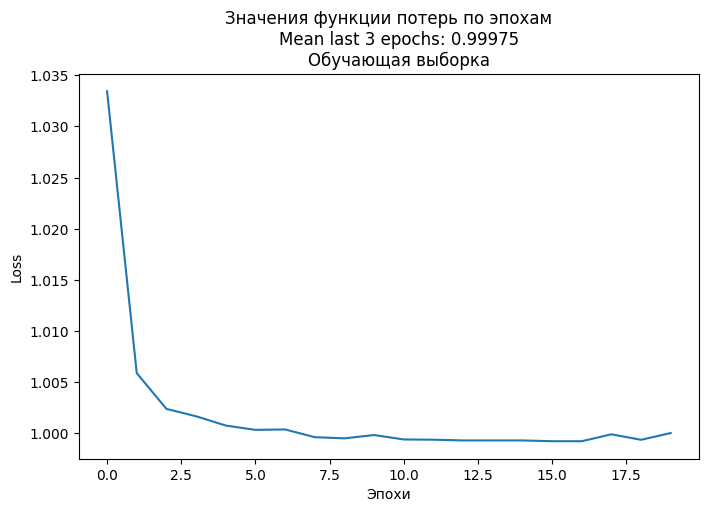

In [ ]:
loss_plot(loss_values_batch, num_last_epochs_=3, 
          add_to_title_='Обучающая выборка')

### Проверка на валидационной выборке

In [ ]:
print(f'Model validating STARTED')
    
model.eval()
y_pred = np.array(0)
y_true = np.array(0)

all_logits = []

with torch.no_grad():
    for batch in tqdm(dataloader_val, total=len(dataloader_val)):
      X, mask, y = tuple(t.to(DEVICE) for t in batch)
      output = model(X, mask)
      all_logits.append(output)
      #y_pred = np.hstack([y_pred, torch.argmax(output, dim=1).cpu().numpy()])
      y_pred = np.hstack(
          [y_pred, 
           torch.argmax(
               nn.functional.log_softmax(output, dim=1),
               dim=1
               ).cpu().numpy()])
      
      y_true = np.hstack([y_true, y.cpu().numpy()])

y_true = y_true[1:]
y_pred = y_pred[1:]

f1_score_ = f1_score(y_true, y_pred, average=AVG_F1)

print()
print(f'F1 macro score = {f1_score_}')

print(f'Model validating COMPLETE')

Model validating STARTED


100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


F1 macro score = 0.9034890320033558
Model validating COMPLETE


### Обучение на полной тренировочной выборке

In [ ]:
# Полный тренировочный набор данных: 
# X_full_train -> X_full_train_tokens, y_full_train
print('X test len =', len(X_full_train))
print('y test len =', len(y_full_train))

X test len = 1586
y test len = 1586


In [ ]:
# Размер батча для даталоадера. 
# Для Google Collab free установить ~ 32..64
batch_size = 32

# Преобразование таргетов в np.array если не было сделано раньше
if type(y_full_train) is not np.ndarray:
    y_full_train = y_full_train.astype('int64').to_numpy()

# Создание даталоадеров для трейн и валидационной выборки
dataloader_full_train = DataLoader(
    dataset=TensorDataset(
        torch.tensor(X_full_train_tokens['input_ids']).to(DEVICE),
        torch.tensor(X_full_train_tokens['attention_mask']).to(DEVICE),
        torch.from_numpy(y_full_train).to(DEVICE)
        ), batch_size=batch_size, shuffle=True
        )

In [ ]:
# Определение весов целевых классов для использования в функции потерь
# Для полного обучающего набора (train + val)

class_weights_train_full = compute_class_weight(
    class_weight='balanced',
    classes=np.array(list(labels_dict.keys())),
    y=y_train)

print(f'Определенные веса классов:\n\
{class_weights_train_full}')

weights_train_full = torch.tensor(class_weights_train_full, 
                                  dtype = torch.float).to(DEVICE)

Определенные веса классов:
[0.74206968 1.468107   1.02958153]


In [ ]:
# Входные переменные для модели

input_dim = 768   # Не менять для этой модели. Размерность эмбеддингов BERT
hidden_dim = 768  # Размер скрытого слоя классификатора (или 1 скрытого слоя)
output_dim = 3    # Колво логитов выходного слоя классификатора
                  # Принять равным кол-ву классов
                  # Также используется при инициализации BERT в num_labels
lr_ = 5e-5        # Шаг оптимизтора learning rate (default: 1e-3 = 0.001)

# Функция потерь
loss_fn = nn.CrossEntropyLoss(weight=weights_train_full)
# Инициализация модели 
model_full = BertClassifier(input_dim, hidden_dim, output_dim)
# Инициализация оптимизатора
optimizer = torch.optim.Adam(model_full.parameters(), lr=lr_)

In [ ]:
model_full, loss_values_batch = train_model(
    model_full, loss_fn, optimizer,
    dataloader_full_train, DEVICE, num_epochs_=30
    )

DEVICE SET TO  cuda:0
Model training STARTED
Epoch 1/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


Epoch COMPLETE. Average loss: 1.0509322810173034
Epoch 2/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0073221254348754
Epoch 3/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0045599102973939
Epoch 4/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0028064513206483
Epoch 5/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0008694839477539
Epoch 6/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.000905373096466
Epoch 7/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0004503571987151
Epoch 8/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9995560109615326
Epoch 9/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9993552958965302
Epoch 10/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9994256222248077
Epoch 11/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9994961094856262
Epoch 12/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.000951247215271
Epoch 13/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0004310703277588
Epoch 14/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0007680797576903
Epoch 15/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0019808053970336
Epoch 16/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0006012904644013
Epoch 17/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9997758400440216
Epoch 18/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0004293823242187
Epoch 19/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0002970254421235
Epoch 20/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0004191076755524
Epoch 21/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.999648756980896
Epoch 22/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 0.9995704185962677
Epoch 23/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.000168056488037
Epoch 24/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0002839720249177
Epoch 25/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0016406393051147
Epoch 26/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.001249680519104
Epoch 27/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0001776313781738
Epoch 28/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0003282070159911
Epoch 29/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch COMPLETE. Average loss: 1.0015809082984923
Epoch 30/30 STARTED


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]

Epoch COMPLETE. Average loss: 1.0019100725650787
Model training COMPLETE


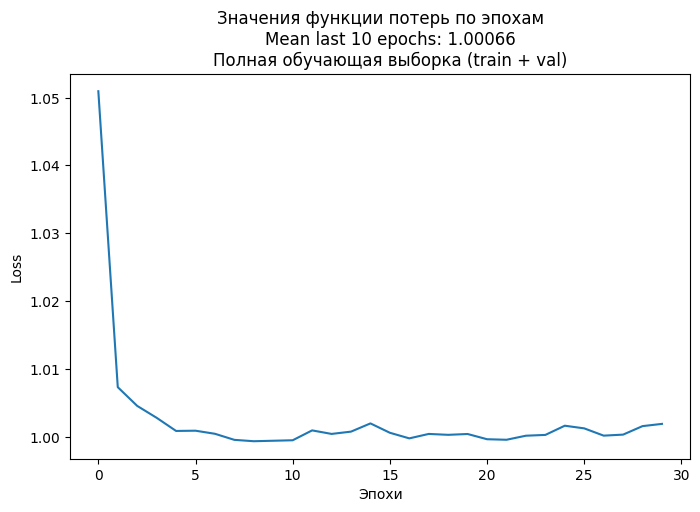

In [ ]:
loss_plot(loss_values_batch, num_last_epochs_=10, 
          add_to_title_='Полная обучающая выборка (train + val)')

### Сохранение модели и токензатора

In [ ]:
MODEL_FILE_NAME = 'model.pth'
TOKENIZER_DIR_NAME = 'tokeniezer'

torch.save(model_full, MODEL_FILE_NAME)
tokenizer.save_pretrained(TOKENIZER_DIR_NAME)

('tokeniezer/tokenizer_config.json',
 'tokeniezer/special_tokens_map.json',
 'tokeniezer/vocab.txt',
 'tokeniezer/added_tokens.json',
 'tokeniezer/tokenizer.json')

### Загрузка сохраненных модели и токенизатора

In [ ]:
model_loaded = torch.load(MODEL_FILE_NAME)
tokenizer_loaded = AutoTokenizer.from_pretrained(TOKENIZER_DIR_NAME)

DEVICE_TEST = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
max_length_test = 160

### Проверка модели на тестовой выборке

In [ ]:
# Тестовый набор данных: X_test -> y_test = 
print(f'X test len = {len(X_test)}, type is {type(X_test)}')
print(f'y test len = {len(y_test)}, type is {type(y_test)}')

X test len = 177, type is <class 'pandas.core.series.Series'>
y test len = 177, type is <class 'pandas.core.series.Series'>


In [ ]:
def series_ptrn_replace(
    series_, 
    ptrn_=r'(\b[А-ЯЁ]+\b)|(\b[а-яё]+[А-ЯЁ]+\b)|(\b[а-яё]+[А-ЯЁ]+[а-яё]+\b)'
    ):
    '''
    series_: pd.Series with texts
    ptrn_: regex patter
    Text preprocessing. Pattern reduction to lowercase
    Default template (Cyrillic only)
    ['сЛОВО' | 'cЛОВо' | 'СЛОво' | 'СЛОВО'] -> 'слово'
    Но 'Слово' -> 'Слово' (не изменяется)
    '''

    def lower_(match_): 
        return str.lower(match_.group())
        
    if type(series_) is not pd.core.series.Series:
        try:
            series_ = pd.Series(series_)
            print('Преобразовано в pd.Series.')
        except:
            print('Преобразование в pd.Series не удалось!')
            return series_
    try:
        return_series = series_.str.replace(ptrn_, lower_, regex=True)
        print('Обработка завершена успешно.')
    except:
        print('Замена слов по шаблону не удалась!')
        return series_
    return return_series

In [ ]:
# Предобработка текста: замена РЕГИСТР рЕГИСТР регИстр -> регистр
X_test = series_ptrn_replace(X_test)

Обработка завершена успешно.


In [ ]:
# Токенизация текстов ТЕСТОВОЙ выборки.

X_test_tokens = tokenizer_loaded.batch_encode_plus(
    X_test.to_list(),
    max_length = max_length_test,
    padding = 'max_length',
    truncation = True,
    add_special_tokens = True, #default
    is_split_into_words = False, #default
)

In [ ]:
# Размер батча для даталоадера. 
# Для Google Collab free установить ~ 32..64
batch_size = 32

# Преобразование таргетов в np.array если не было сделано раньше
if type(y_test) is not np.ndarray:
    y_test = y_test.astype('int64').to_numpy()

# Создание даталоадеров для тестовой выборки
dataloader_test = DataLoader(
    dataset=TensorDataset(
        torch.tensor(X_test_tokens['input_ids']).to(DEVICE_TEST),
        torch.tensor(X_test_tokens['attention_mask']).to(DEVICE_TEST),
        torch.from_numpy(y_test).to(DEVICE_TEST)
        ), batch_size=batch_size, shuffle=False
        )

In [ ]:
def get_pred(model_, dataloader_):
    '''
    '''
    model_.eval()
    y_pred = np.array(0)

    with torch.no_grad():
        for batch in dataloader_:
          X, mask, y = tuple(t.to(DEVICE) for t in batch)
          output = model_(X, mask)
          y_pred = np.hstack(
              [y_pred, torch.argmax(nn.functional.log_softmax(output, dim=1),
                                    dim=1).cpu().numpy()]
                             )
    y_pred = y_pred[1:]

    return y_pred

### Результаты проверки

In [ ]:
test_pred = get_pred(model_loaded, dataloader_test)
f1_score_test = f1_score(y_test, test_pred, average='macro')
print(f'F1 score (macro) on test set = {f1_score_test}')

F1 score (macro) on test set = 0.9325752380109585


In [ ]:
series_to_return = pd.Series(test_pred, name='class_predicted').map(labels_dict) 
print(series_to_return)

0       Магазин
1      Доставка
2      Доставка
3      Доставка
4         Товар
         ...   
172    Доставка
173       Товар
174    Доставка
175       Товар
176     Магазин
Name: class_predicted, Length: 177, dtype: object


In [ ]:
outp_df = pd.DataFrame({'text': X_test,
                        'class_true': pd.Series(y_test).map(labels_dict).to_list(),
                        'class_labels_true': pd.Series(y_test).to_list(),
                        'class_predicted': series_to_return.to_list(),
                       })

In [ ]:
outp_df.head(19)

,text,class_true,class_labels_true,class_predicted
1418,"Не компетентные сотрудники, не знают регламент...",Магазин,1,Магазин
1488,"Курьер не звонил заранее за час, как обычно пр...",Доставка,0,Доставка
791,мне не выдали заказ без обьяснения причин= зак...,Доставка,0,Доставка
167,За час не звонили. Пришлось всё бросить и сро...,Доставка,0,Доставка
1630,"в зоне выдачи отсутствуют бесплатные пакеты, д...",Товар,2,Товар
968,Витринныц образец Такая красота обошлась в по...,Товар,2,Товар
1535,1. Дорогая доставка,Доставка,0,Доставка
830,"Сотрудники просто игнорировали меня, при чем я...",Магазин,1,Магазин
526,почему товар перед доставкой никто не проверя...,Товар,2,Товар
1067,"Привезли только один товар из двух, частично п...",Доставка,0,Доставка


### Добавление NER меток

#### Подготовка образца с отзывами для предсказания классов и простановки меток NER

In [ ]:
sample_ner = data[220:280]
X_ner = sample_ner['text']
X_ner = series_ptrn_replace(X_ner)
y_ner = sample_ner['class_labels']

Обработка завершена успешно.


In [ ]:
X_ner_tokens = tokenizer_loaded.batch_encode_plus(
    X_ner.to_list(),
    max_length = 160,
    padding = 'max_length',
    truncation = True,
    add_special_tokens = True, #default
    is_split_into_words = False, #default
)

In [ ]:
# Размер батча для даталоадера.
# Для Google Collab free установить ~ 32..64
batch_size = 32

# Преобразование таргетов в np.array если не было сделано раньше
if type(y_ner) is not np.ndarray:
    y_ner = y_ner.astype('int64').to_numpy()

# Создание даталоадеров для тестовой выборки
dataloader_ner = DataLoader(
    dataset=TensorDataset(
        torch.tensor(X_ner_tokens['input_ids']).to(DEVICE_TEST),
        torch.tensor(X_ner_tokens['attention_mask']).to(DEVICE_TEST),
        torch.from_numpy(y_ner).to(DEVICE_TEST)
        ), batch_size=batch_size, shuffle=False
        )

test_ner = get_pred(model_loaded, dataloader_ner)

In [ ]:
series_ner = pd.Series(test_ner, name='class_predicted').map(labels_dict) 
sample_ner['class_predicted'] = series_ner.to_list()

<ipython-input-48-da92cb4289d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_ner['class_predicted'] = series_ner.to_list()


#### Загрузка предобученной модели DeepPavlov ner_rus_bert_probas

In [ ]:
!pip install -q deeppavlov

In [ ]:
!python -m deeppavlov install ner_rus_bert_probas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from deeppavlov import configs, build_model

In [ ]:
config_path = configs.ner.ner_rus_bert_probas
configs.ner.ner_rus_bert_probas

ner_wiki = build_model(config_path, download=True)

2023-04-05 00:51:50.657 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/deeppavlov_data/rus_dream_entity_detection/wiki_ner_rus_bert.tar.gz download because of matching hashes
INFO:deeppavlov.download:Skipped http://files.deeppavlov.ai/deeppavlov_data/rus_dream_entity_detection/wiki_ner_rus_bert.tar.gz download because of matching hashes
2023-04-05 00:51:53.215 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/datasets/wiki_ner_rus/wiki_ner_rus_dataset.tar.gz download because of matching hashes
INFO:deeppavlov.download:Skipped http://files.deeppavlov.ai/datasets/wiki_ner_rus/wiki_ner_rus_dataset.tar.gz download because of matching hashes
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predicti

### Простановка меток NER на образце

In [ ]:
def add_ner_labels(series_, text_column_='text', model_ner_=ner_wiki):
    '''
    series_: pd.Series at least one of the elements must contain text
    text_column_: name of index of element that containing text
    model_ner_: DeepPavlov TorchTransformersNerPreprocessor
    The function creates a string with recognized entities
    using the DeepPavlov model
    Returns: str, like 'word[ner_label] word[ner_label]'
    '''
    output = model_ner_([series_[text_column_]])
    out_str = ''
    for tok, tag in zip(output[0][0], output[2][0]):
        if tag != 'O':
            out_str += f'{tok}[{tag}] '
    return out_str

In [ ]:
sample_ner['NER'] = sample_ner.apply(add_ner_labels, axis=1, result_type='reduce', args = ('text', ner_wiki))

<ipython-input-54-305e0cdf1c07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_ner['NER'] = sample_ner.apply(add_ner_labels, axis=1, result_type='reduce', args = ('text', ner_wiki))


In [ ]:
sample_ner

,text,class,class_labels,class_predicted,NER
220,Добрый день. В комментарии для курьера специал...,Доставка,0,Доставка,
221,продали неаккуратно вскрытую упаковку!! покуп...,Товар,2,Товар,
222,Доставка и пункт выдачи оставляют желать лучшего,Доставка,0,Доставка,
223,Очень долгое ожидание выдачи заказа,Доставка,0,Доставка,
224,при заказе не было уточнено что товар с витрин...,Товар,2,Товар,
225,Заказал с курьерской доставкой сказали что при...,Доставка,0,Доставка,
226,И больше выбор товаров!,Товар,2,Товар,
227,"Видимо магазин новый, немного неотлаженно рабо...",Доставка,0,Доставка,
228,"Заказ отменил, курьер не дал проверить товар и...",Доставка,0,Доставка,
229,Почему курьер не позвонил перед выездом? В ито...,Доставка,0,Доставка,
